<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Прототип машинного обучения для компании "Цифра"

Цель проекта - подготовка прототипа машинного обучения для "Цифры". Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, что бы не запускать предприятие с убыточными характеристиками

В ходе проекта необходимо :
  1. Подготовить данные
  2. Провести исследовательский анализ
  3. Построить и обучить модель

# Описание данных

**Технологический просесс**

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
*Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

Наименование признаков выглядит следующим образом:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Подготовка данных

In [1]:
# Импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [2]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Проверим правильно ли расчитана эффективность обогащения. 

Формула выглядит так: `recovery = ((C * (F - T)) / (F * (C - T))) * 100`

Где:
  * С - Доля золота в концентрате после флотации/очистки
  * F - Доля золота в сырье/концентрате до флотации/очистки
  * Т - Доля золота в отвальных хвостах после флотации/очистки

Таким образом:
  * С - rougher.output.concentrate_au
  * А - rougher.input.feed_au 
  * Т - rougher.output.tail_au

А сам результат работы формулы - `rougher.output.recovery`

Проверим, что эффективность обогащения рассчитана правильно. Вычислим ее по формуле на обучающей выборке для признака `rougher.output.recovery`. Найдем MAE между нашими расчетами и значениями признака.


In [6]:
# Избавимся от пропусков в столбце rougher.output.recovery
df_train.dropna(subset=['rougher.output.recovery'], inplace=True)

In [7]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [8]:
recovery = ((C * (F - T)) / (F * (C - T))) * 100

Построим гистограммы для двух наборов значений recovery - старых и новых.

In [9]:
old_recovery = df_train['rougher.output.recovery']

<AxesSubplot:>

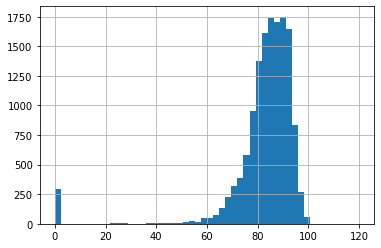

In [10]:
old_recovery.hist(bins=50, range=(0, 120))

<AxesSubplot:>

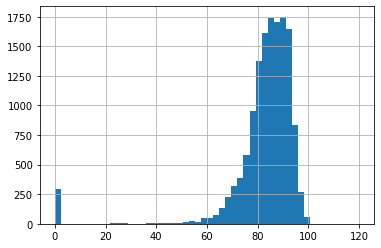

In [11]:
recovery.hist(bins=50, range=(0, 120))

По графику не видно разницы между старыми данными и новыми. Посчитаем MAE.

In [12]:
print('MAE: ', mean_absolute_error(recovery, old_recovery))

MAE:  9.73512347450521e-15


МАЕ близко к нулю, следовательно разницы между старыми данными и новыми нет, расчеты верны.

Сравним наполнение признаками тестовой и тренировочной выборки.

In [13]:
print(df_train.shape)
print(df_test.shape)

(14149, 87)
(5290, 53)


В обучающей выборке признакорв примерно на треть больше чем в тестовой. Проанализруем недоступные признаки в тестовой выборке

In [14]:
missing_cols = df_train.columns.drop(df_test.columns)
df_train[missing_cols].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


Эти столбцы - концентрация различных веществе на выходе, а так же доля веществ в отвальных хвостах.

Выходит у нас есть 53 признака(тех, что в тестовой выборке) и 2 целевых признака - `rougher.output.recovery` и `final.output.recovery`

Осталось удалить лишние признаки из тренировочной выборки и добавить два целевых признака в тестовую

In [15]:
columns_to_drop = missing_cols.drop(['rougher.output.recovery', 'final.output.recovery'])
right_columns = df_train.columns.drop(columns_to_drop)
df_train = df_train[right_columns]

Обучающая выборка готова.
Займемся тестовой: столбец `date` в исходной выборке имеет уникальные значения. Их можно использовать как индексы, что бы объединить датасеты и добавить в тестовую выборку отсутствующие столбцы. 

In [16]:
cols_to_join = df_full[['date', 'rougher.output.recovery', 'final.output.recovery']].copy()
df_test = df_test.join(cols_to_join.set_index('date'), on='date')

In [17]:
print(df_train.shape)
print(df_test.shape)

(14149, 55)
(5290, 55)


Обучающая и тестовая выборка готовы.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [18]:
# Подготовим датасеты с необходимыми данными для золота
au = df_full[['rougher.input.feed_au',
             'rougher.output.concentrate_au',
             'primary_cleaner.output.concentrate_au',
             'final.output.concentrate_au']].copy()

In [19]:
# Серебра
ag = df_full[['rougher.input.feed_ag',
             'rougher.output.concentrate_ag',
             'primary_cleaner.output.concentrate_ag',
             'final.output.concentrate_ag']].copy()

In [20]:
# Свинца
pb = df_full[['rougher.input.feed_pb',
             'rougher.output.concentrate_pb',
             'primary_cleaner.output.concentrate_pb',
             'final.output.concentrate_pb']].copy()

Напишем функцию, которая будет рисовать данные всех 4х столбцов на одном графике.

In [21]:
def hist(data, title):
  fig, ax = plt.subplots()
  ax.set_ylabel('Количество наблюдений')
  ax.set_xlabel('Концентрация металла')
  ax.set_title(title)
  for col in data:
    data[col].hist(alpha=.3)
    ax.legend(['Исходное сырье', 'Флотация', 'Первичная очистка', 'Вторичная очистка'])

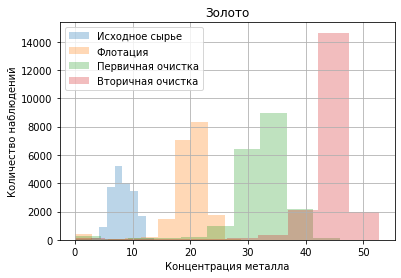

In [22]:
hist(au, 'Золото')

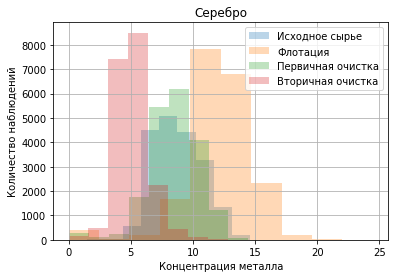

In [23]:
hist(ag, 'Серебро')

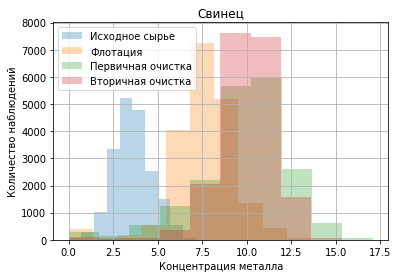

In [24]:
hist(pb, 'Свинец')

* Для разных металлов концентрация на различных этапах очистки отличается. 
  1. Концентрация золота увеличивается с каждым этапом очистки
  2. Концентрация серебра после вторичной очистки меньше, чем в исходном сырье
  3. Концентрация свинца после первичной и вторичной очистки не меняется.
* В данных присутствуют нулевые значения. От них необходимо будет избавиться, так как они могут повлиять на качество модели.

Сравним распределение размеров гранул сырья на обучающей и тестовой выборка.
Если распределение будет сильно отличаться, оценка модели будет неправильной.

В датасетах есть два признака с параметром `feed_size` в обучающей и тестовой выборках - это `primary_cleaner.input.feed_size` и `rougher.input.feed_size`

<AxesSubplot:>

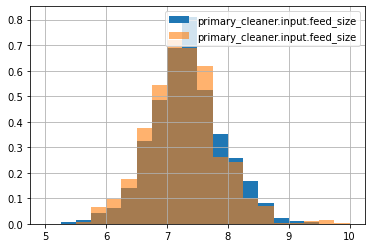

In [25]:
df_train['primary_cleaner.input.feed_size'].hist(bins=20, range=(5, 10), density=True, legend=True)
df_test['primary_cleaner.input.feed_size'].hist(bins=20, range=(5, 10), density=True, legend=True, alpha=0.6)


<AxesSubplot:>

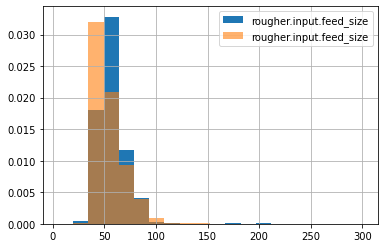

In [58]:
df_train['rougher.input.feed_size'].hist(bins=20, range=(0, 300), density=True, legend=True)
df_test['rougher.input.feed_size'].hist(bins=20, range=(0, 300), density=True, legend=True, alpha=0.6)


Для обоих параметров распеделение не сильно отличается на выборках. Такие неточности не должны критично повлиять на результат работы модели.

Исследуем суммарную концентрацию всех веществ на разных стадиях:
 * В сырье
 * В черновом
 * В финальном концентрате

In [30]:
concentrate_data = df_full[['date','rougher.input.feed_ag', 'rougher.input.feed_pb', 
                              'rougher.input.feed_sol', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 
                              'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 
                              'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 
                              'final.output.concentrate_au']].copy()

concentrate_data['conc_sum_rougher'] = (concentrate_data['rougher.input.feed_ag'] + 
                                        concentrate_data['rougher.input.feed_pb'] + 
                                        concentrate_data['rougher.input.feed_sol'] + 
                                        concentrate_data['rougher.input.feed_au'])

concentrate_data['conc_sum_primary'] = (concentrate_data['primary_cleaner.output.concentrate_ag'] + 
                                        concentrate_data['primary_cleaner.output.concentrate_pb'] + 
                                        concentrate_data['primary_cleaner.output.concentrate_sol'] + 
                                        concentrate_data['primary_cleaner.output.concentrate_au'])

concentrate_data['conc_sum_final'] = (concentrate_data['final.output.concentrate_ag'] + 
                                      concentrate_data['final.output.concentrate_pb'] + 
                                      concentrate_data['final.output.concentrate_sol'] + 
                                      concentrate_data['final.output.concentrate_au'])


Построим гистограммы

Text(0, 0.5, 'Количество наблюдений')

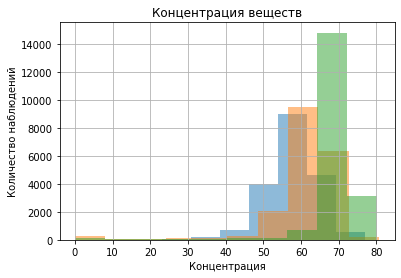

In [31]:
concentrate_data['conc_sum_rougher'].hist(alpha=.5)
concentrate_data['conc_sum_primary'].hist(alpha=.5)
concentrate_data['conc_sum_final'].hist(alpha=.5)
plt.title('Концентрация веществ')
plt.xlabel('Концентрация')
plt.ylabel('Количество наблюдений')

На графике заментны нулевые значения. Лучше от них избавиться, что бы они не повлияли на качество модели.

In [32]:
outlier = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0').fillna(0))
outlier.head()

,date,conc_sum_rougher,conc_sum_primary,conc_sum_final
19,2016-01-15 19:00:00,56.005644,0.0,64.546766
22,2016-01-15 22:00:00,56.038252,0.0,64.554911
30,2016-01-16 06:00:00,57.764677,0.0,63.765751
71,2016-01-18 01:00:00,56.626743,0.0,65.773298
74,2016-01-18 04:00:00,56.369424,0.0,59.902215


Избавимся от выбросов в тестовой выборке.

In [33]:
df_test = df_test.join(outlier.set_index('date'), on='date')
df_test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = df_test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']].fillna(-1)
df_test = df_test.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')


<AxesSubplot:>

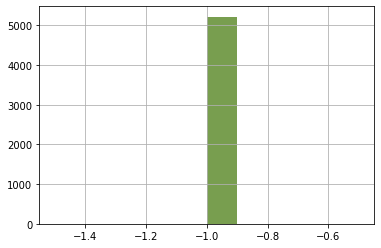

In [34]:
df_test['conc_sum_rougher'].hist(alpha=.5)
df_test['conc_sum_primary'].hist(alpha=.5)
df_test['conc_sum_final'].hist(alpha=.5)

Значения всех признаков -1, значит все выполнилось правильно.
Теперь удалим эти столбцы.

In [35]:
df_test.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis=1, inplace=True)

Теперь повторим все тоже самое для тренировочной выборки.

In [36]:
df_train = df_train.join(outlier.set_index('date'), on='date')
df_train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = df_train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']].fillna(-1)
df_train = df_train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')
df_train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis=1, inplace=True)

Удалим оставшиеся пропуски.

In [37]:
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)

In [38]:
print(df_train.shape)
print(df_test.shape)

(12593, 55)
(5169, 55)


## Модель

Напишем функицию для расчета метрики sMAPE.

In [39]:
def smape(target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

И функцию для расчета итогового sMAPE.

In [40]:
def final_smape(rougher, final):
  return 0.25 * rougher + 0.75 * final

Подготовим features и target для обучающей выборки.

In [41]:
target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']

features_train = df_train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1)

Масштабируем признаки.

In [42]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

In [43]:
score = make_scorer(smape, greater_is_better=False)

С помощью кросс-валидации проверим разные модели и выберем лучшую.

In [44]:
model_dtr = DecisionTreeRegressor(random_state=777)
rougher_model_dtr = cross_val_score(model_dtr, features_train, target_train_rougher, scoring=score).mean()
final_model_dtr = cross_val_score(model_dtr, features_train, target_train_final, scoring=score).mean()
print(rougher_model_dtr)
print(final_model_dtr)

-20.731344782050588
-16.683001791842663


In [45]:
model_lr = LinearRegression()
rougher_model_lr = cross_val_score(model_lr, features_train, target_train_rougher, scoring=score).mean()
final_model_lr = cross_val_score(model_lr, features_train, target_train_final, scoring=score).mean()
print(rougher_model_lr)
print(final_model_lr)

-10.757232685937554
-10.321641566366015


In [46]:
%%time
model_rf = RandomForestRegressor(random_state=777, n_estimators=10)
rougher_model_rf = cross_val_score(model_rf, features_train, target_train_rougher, scoring=score).mean()
final_model_rf = cross_val_score(model_rf, features_train, target_train_final, scoring=score).mean()
print(rougher_model_rf)
print(final_model_rf)

-13.009079687970146
-10.13510873753921
CPU times: user 48.6 s, sys: 1.23 ms, total: 48.6 s
Wall time: 48.7 s


In [59]:
parametrs = {'n_estimators' :  range(1, 10, 3),
             'max_depth' : range(4, 10, 2)}
grid = RandomizedSearchCV(model_rf, parametrs, cv=3, verbose=3, scoring=score)
grid.fit(features_train, target_train_final)
grid.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 2/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 3/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 1/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 2/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 3/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 1/3] END ....................max_depth=4, n_estimators=7; total time=   0.7s
[CV 2/3] END ....................max_depth=4, n_estimators=7; total time=   0.7s
[CV 3/3] END ....................max_depth=4, n_estimators=7; total time=   0.7s
[CV 1/3] END ....................max_depth=6, n_estimators=1; total time=   0.2s
[CV 2/3] END ....................max_depth=6, n_estimators=1; total time=   0.1s
[CV 3/3] END ....................max_depth=6, n_e

-9.56618751559097

In [60]:
parametrs = {'n_estimators' :  range(1, 10, 3),
             'max_depth' : range(4, 10, 2)}
grid = RandomizedSearchCV(model_rf, parametrs, cv=3, verbose=3, scoring=score)
grid.fit(features_train, target_train_rougher)
grid.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 2/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 3/3] END ....................max_depth=4, n_estimators=1; total time=   0.1s
[CV 1/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 2/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 3/3] END ....................max_depth=4, n_estimators=4; total time=   0.4s
[CV 1/3] END ....................max_depth=4, n_estimators=7; total time=   0.8s
[CV 2/3] END ....................max_depth=4, n_estimators=7; total time=   0.7s
[CV 3/3] END ....................max_depth=4, n_estimators=7; total time=   0.8s
[CV 1/3] END ....................max_depth=6, n_estimators=1; total time=   0.2s
[CV 2/3] END ....................max_depth=6, n_estimators=1; total time=   0.2s
[CV 3/3] END ....................max_depth=6, n_e

-10.713971813267605

Наилучший результат дала модель линейной регрессии.
Подготовим target и features для тестовой выборки и масштабируем признаки.


In [50]:
target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

features_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [51]:
scaler = StandardScaler()
scaler.fit(features_test)
features_test = scaler.transform(features_test)

In [52]:
model = LinearRegression()
model_1 = LinearRegression()

model.fit(features_train, target_train_rougher)
model_1.fit(features_train, target_train_final)

predicted_rougher = model.predict(features_test)
predicted_final = model_1.predict(features_test)

Посчитаем sMAPE и итоговый sMAPE.

In [53]:
smape_rougher = smape(target_test_rougher, predicted_rougher)
smape_final = smape(target_test_final, predicted_final)

In [54]:
final_smape(smape_rougher, smape_final)

9.49521433561976

Проверим качество модели сравнив ее с константой.

In [55]:
dummy = DummyRegressor(strategy='mean')
dummy_1 = DummyRegressor(strategy='mean')

dummy.fit(features_test, target_test_rougher)
dummy_1.fit(features_test, target_test_final)

dummy_predicted_rougher = dummy.predict(features_test)
dummy_predicted_final = dummy_1.predict(features_test)

In [56]:
dummy_smape_rougher = smape(target_test_rougher, dummy_predicted_rougher)
dummy_smape_final = smape(target_test_final, dummy_predicted_final)

In [57]:
final_smape(dummy_smape_rougher, dummy_smape_final)

7.89053500576828

Обученная модель линейной регрессии предсказывает результат лучше Dummy модели.

**Вывод**

1. Были написанны формулы для расчет sMAPE и итогового sMAPE.
2. С помощью кросс-валидации была выявлена самая точная модель - LinearRegression
3. С помощью Dummy модели проверили обученную модель на адекватность.
4. Прототип модели машинного обучения для "Цифры" готов.